In [1]:
import h5py
import torch
import transformers
from transformers import AutoModelForMaskedLM, AutoTokenizer
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
sys.path.append('/home/ztang/multitask_RNA/data_generation')
import utils
import numpy as np

/home/ztang/.conda/envs/torch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file = h5py.File("/home/ztang/multitask_RNA/data/CAGI/230/CAGI_onehot.h5", "r")
alt = file['alt']
ref = file['ref']

## GPN claim zero shot learning with log p(alt)/p(ref)

Need to mask the center nuceltide of each seq and get the p value

In [6]:
import gpn
import gpn.model
model = AutoModelForMaskedLM.from_pretrained("/home/ztang/multitask_RNA/model/GPN_finetune/checkpoint-2000000").to('cuda')
tokenizer = AutoTokenizer.from_pretrained("/home/ztang/multitask_RNA/model/GPN_finetune/checkpoint-2000000")
model.eval();

ModuleNotFoundError: No module named 'gpn.mlm'

In [4]:
N, L, A = alt.shape
mut_i = int(L/2-1)
cagi_llr=[]
for i in range(1):
    ref_a = np.argmax(ref[i][mut_i])+2
    alt_a = np.argmax(alt[i][mut_i])+2
    seq = utils.onehot_to_seq([ref[i]])
    token = tokenizer.batch_encode_plus(seq)['input_ids'][0]
    token[mut_i] = tokenizer.mask_token_id
    break

In [5]:
torch.tensor([token]).to('cuda')

tensor([[2, 4, 5, 5, 2, 3, 5, 3, 3, 2, 5, 4, 5, 4, 4, 2, 2, 2, 4, 3, 2, 5, 5, 5,
         2, 2, 2, 2, 2, 2, 3, 2, 4, 2, 2, 4, 3, 2, 5, 5, 2, 5, 5, 2, 2, 5, 5, 2,
         5, 5, 2, 2, 4, 4, 2, 3, 5, 5, 2, 5, 5, 5, 4, 3, 5, 3, 2, 2, 5, 4, 2, 5,
         3, 5, 3, 5, 4, 2, 4, 2, 2, 4, 4, 2, 2, 2, 5, 5, 4, 2, 2, 3, 4, 3, 2, 2,
         5, 2, 4, 5, 5, 5, 5, 4, 2, 2, 5, 5, 3, 5, 3, 2, 2, 5, 0, 5, 5, 3, 2, 5,
         4, 5, 5, 5, 3, 3, 3, 3, 3, 4, 5, 2, 5, 4, 5, 4, 3, 4, 5, 4, 3, 4, 3, 2,
         5, 4, 3, 2, 3, 2, 5, 2, 5, 2, 5, 2, 2, 2, 3, 2, 3, 2, 5, 3, 5, 2, 4, 3,
         5, 5, 3, 2, 3, 2, 3, 3, 5, 4, 5, 4, 5, 2, 3, 5, 3, 2, 3, 2, 3, 3, 5, 4,
         5, 4, 5, 4, 5, 2, 3, 2, 3, 2, 3, 5, 3, 3, 5, 3, 3, 5, 4, 5, 2, 3, 2, 5,
         4, 5, 4, 5, 2, 5, 2, 3, 2, 3, 4, 3, 2, 3]], device='cuda:0')

In [6]:
output = model.forward(torch.tensor([token]).to('cuda'))

: 

: 

In [5]:
N, L, A = alt.shape
mut_i = int(L/2-1)
cagi_llr=[]
for i in range(N):
    ref_a = np.argmax(ref[i][mut_i])+2
    alt_a = np.argmax(alt[i][mut_i])+2
    seq = utils.onehot_to_seq([ref[i]])
    token = tokenizer.batch_encode_plus(seq)['input_ids'][0]
    token[mut_i] = tokenizer.mask_token_id
    output = model(torch.tensor([token]).to('cuda')).logits.cpu().detach().numpy()
    llr = output[0][mut_i][alt_a] - output[0][mut_i][ref_a]
    cagi_llr.append(llr)


: 

: 

In [34]:
output = h5py.File('./cagi_gpn.h5', 'w')
output.create_dataset('llr', data=np.array(cagi_llr))

<HDF5 dataset "llr": shape (18442,), type "<f4">

## Visulization


In [1]:
import h5py
import pandas as pd
import numpy as np
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy.stats as stats
cagi_result = h5py.File('./cagi_gpn.h5', 'r')
llr = cagi_result['llr'][()]

In [5]:
cagi_df = pd.read_csv('../../data/CAGI/final_cagi_metadata.csv',
                      index_col=0).reset_index()
exp_list = cagi_df['8'].unique()
plot_figure = True

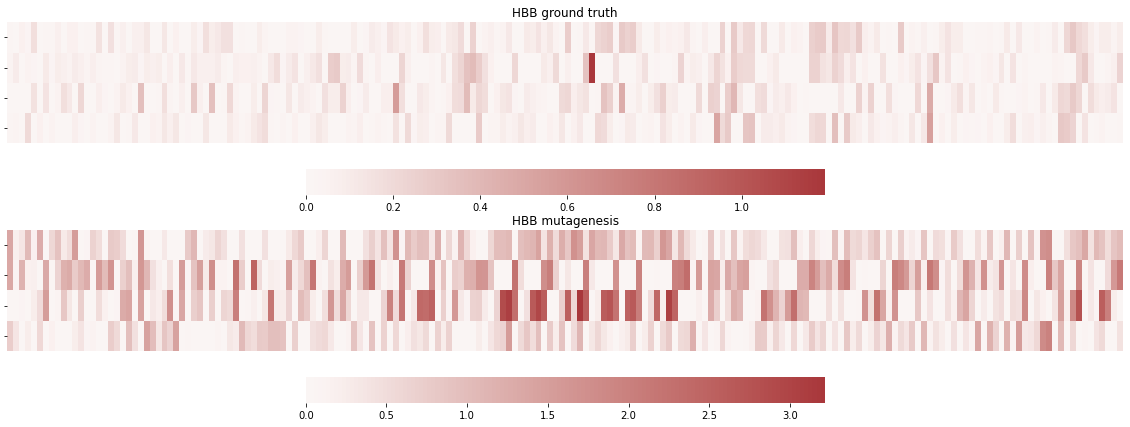

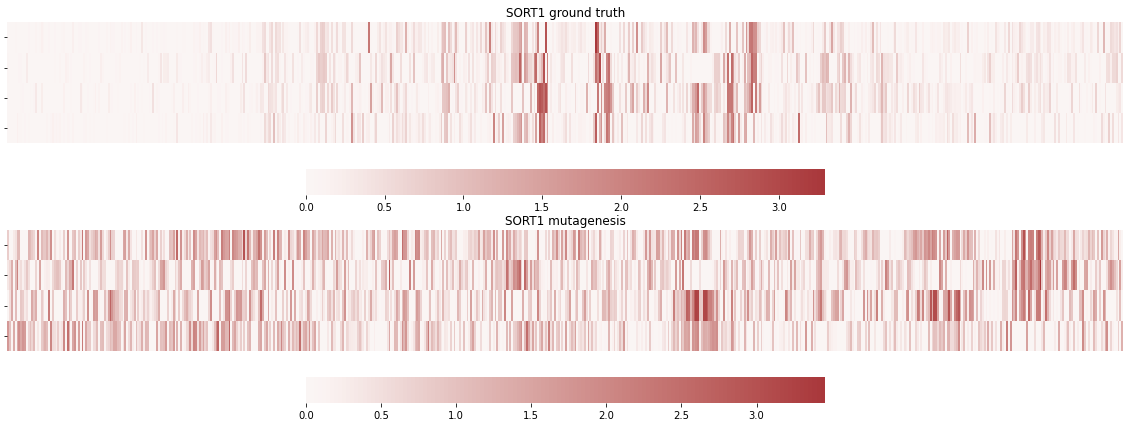

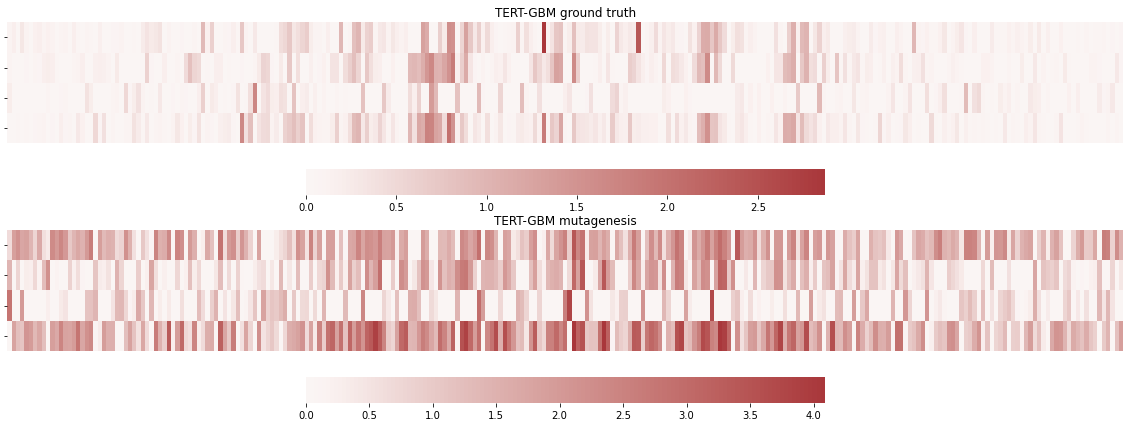

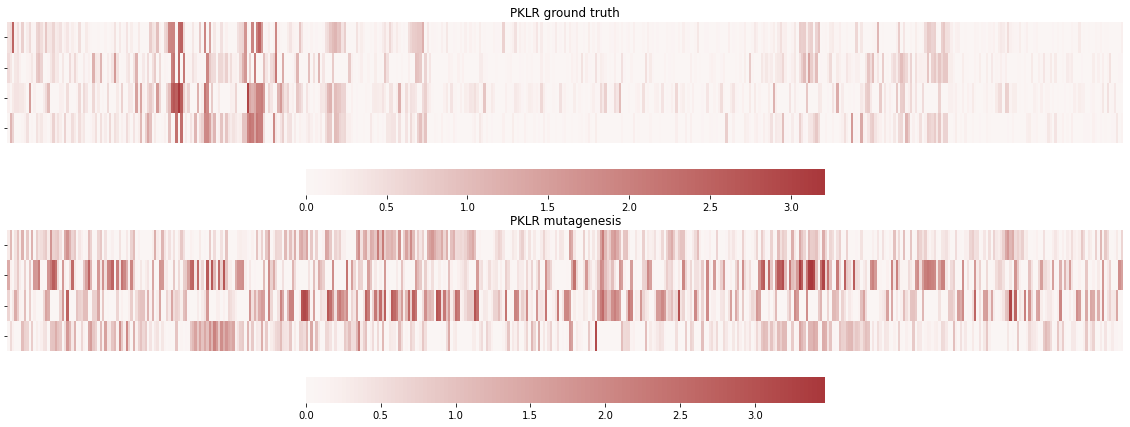

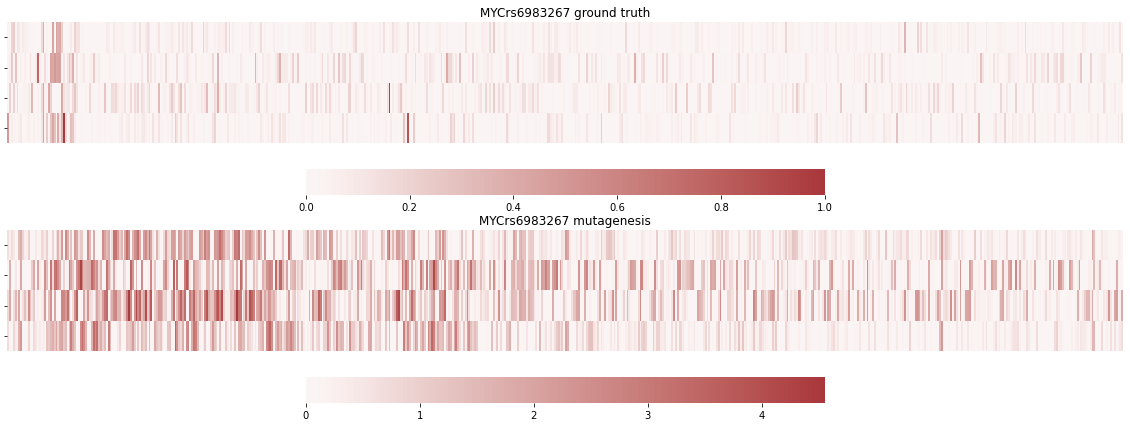

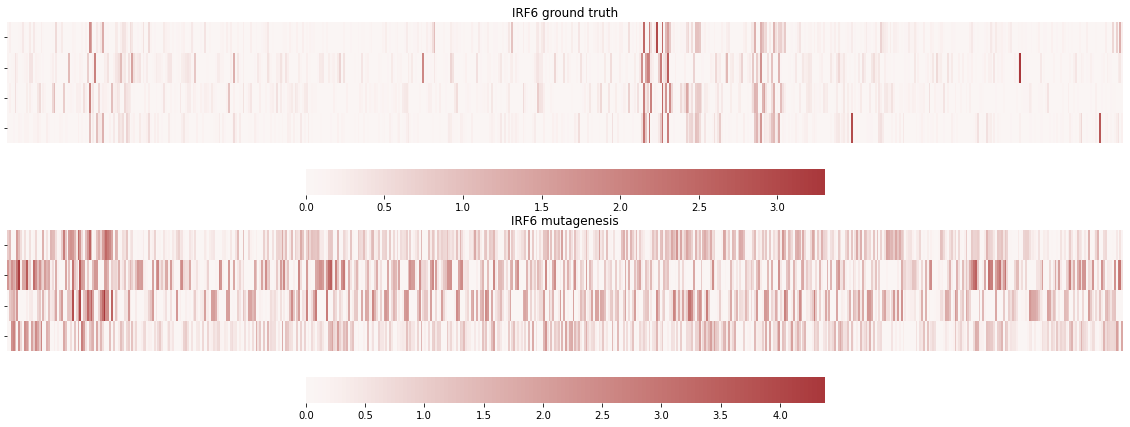

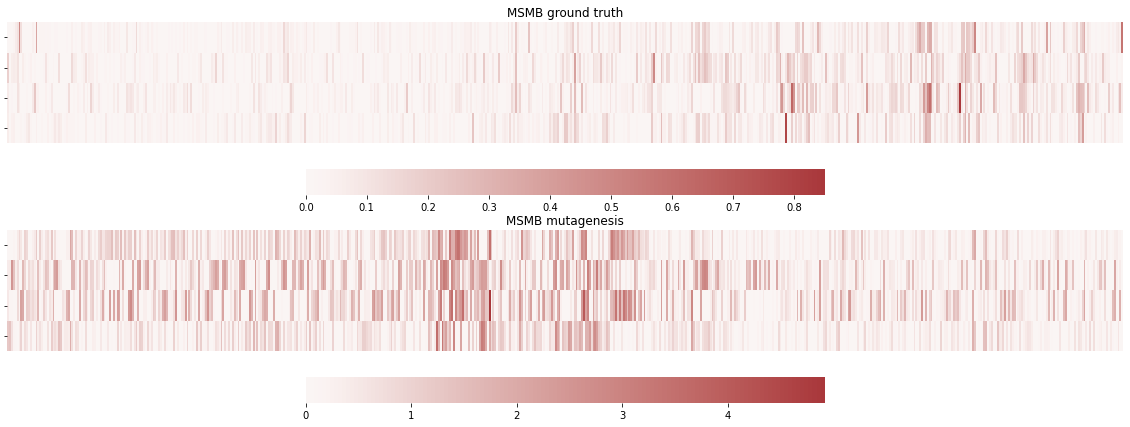

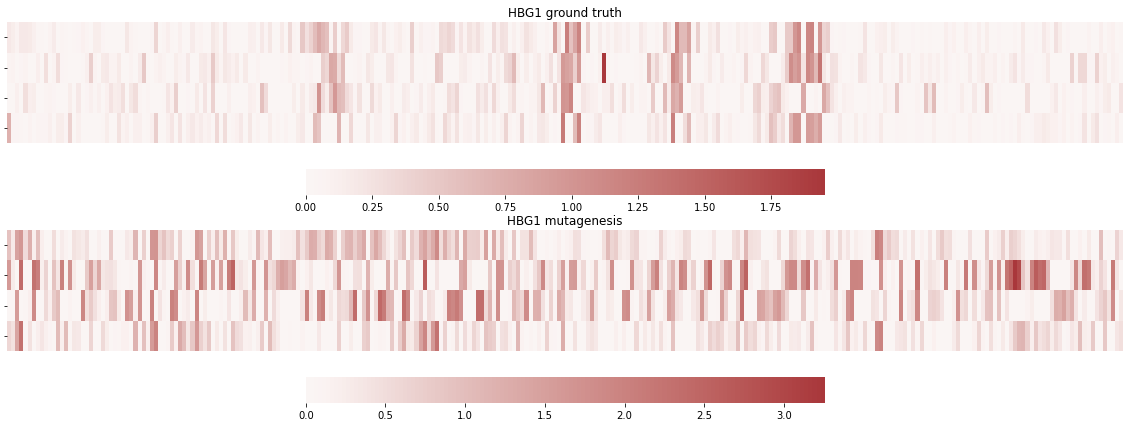

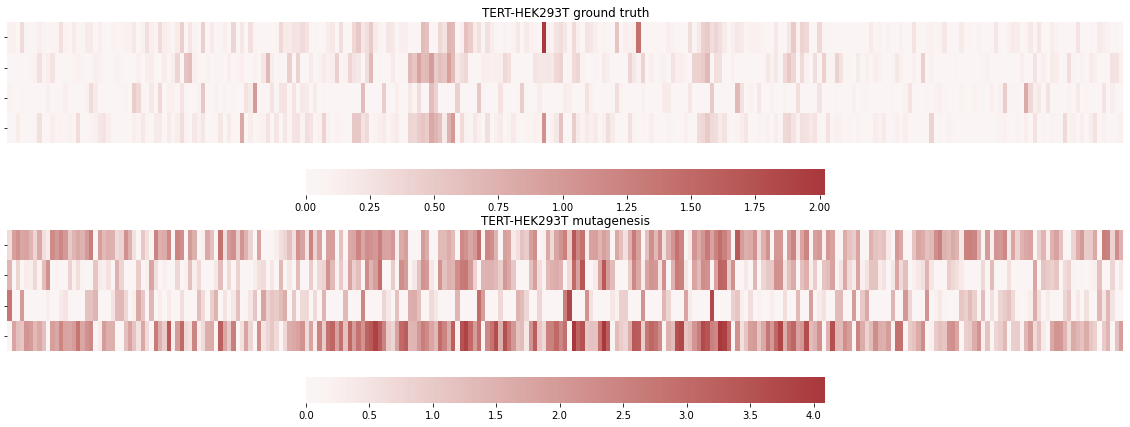

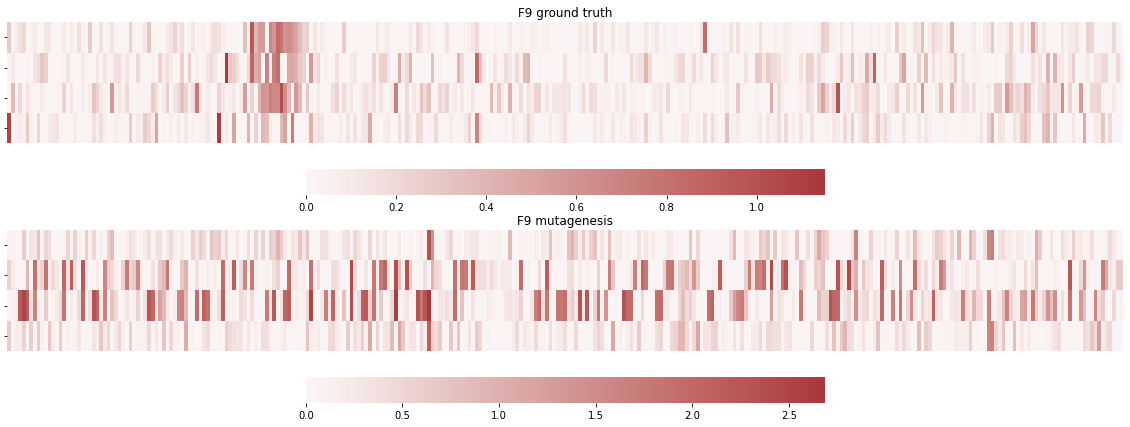

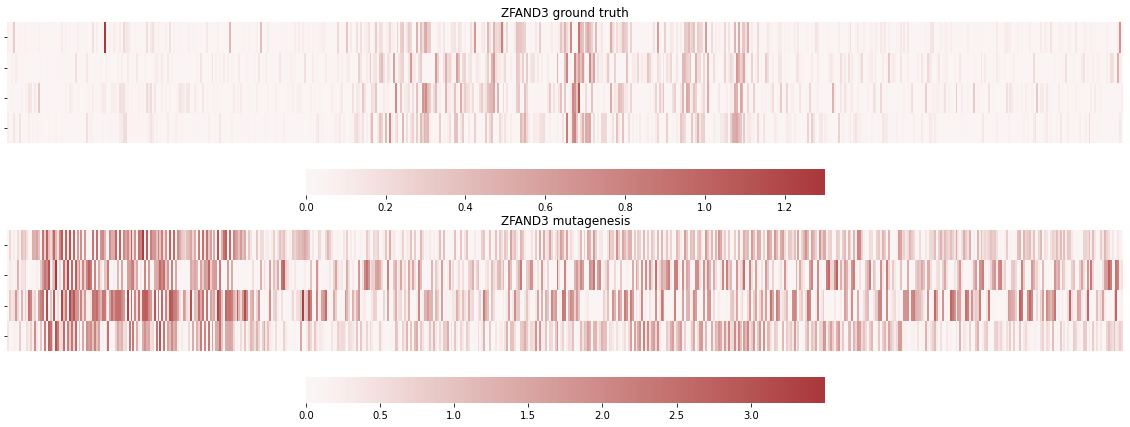

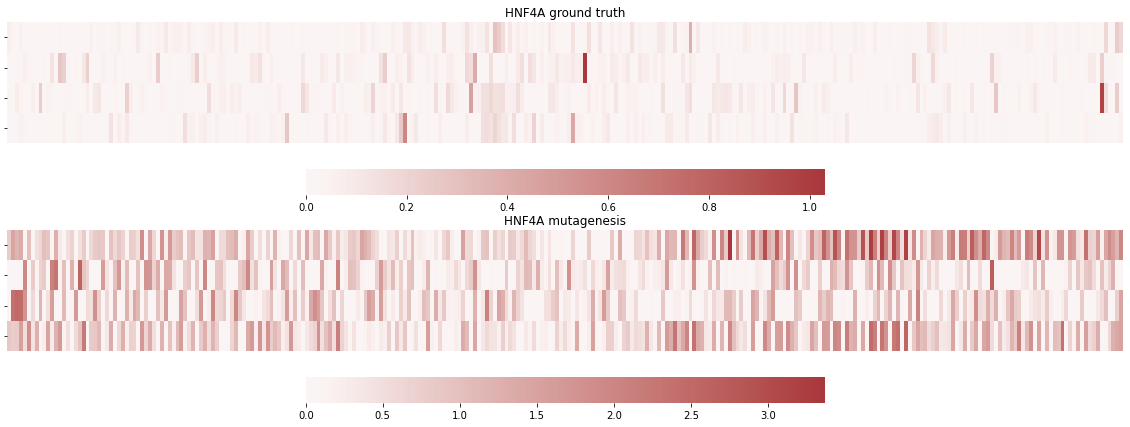

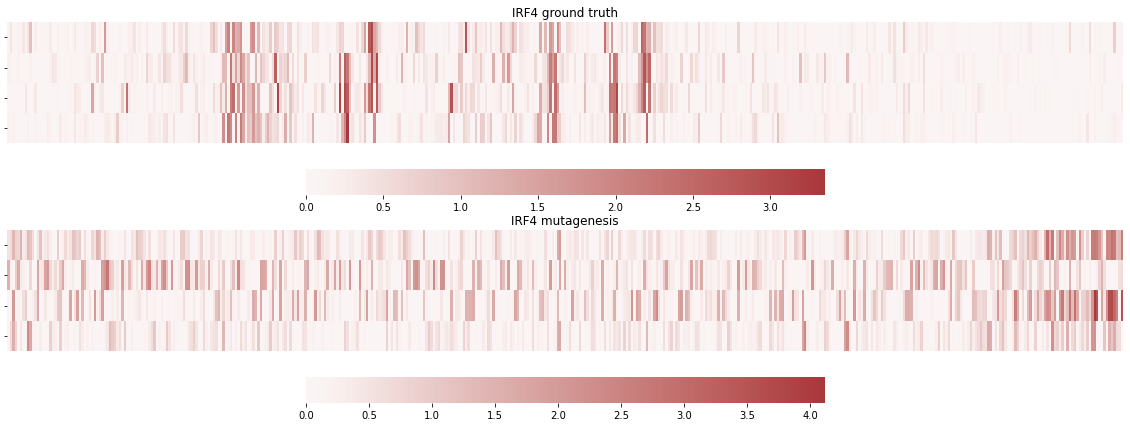

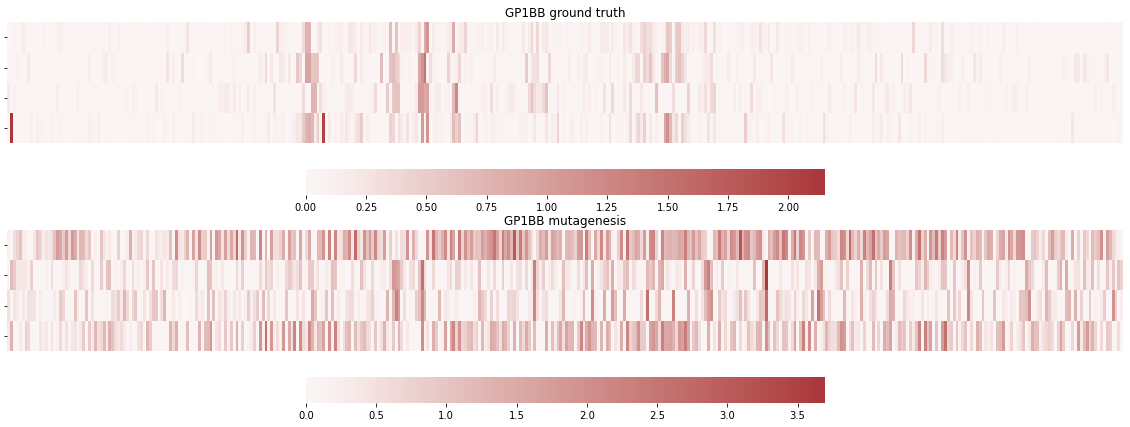

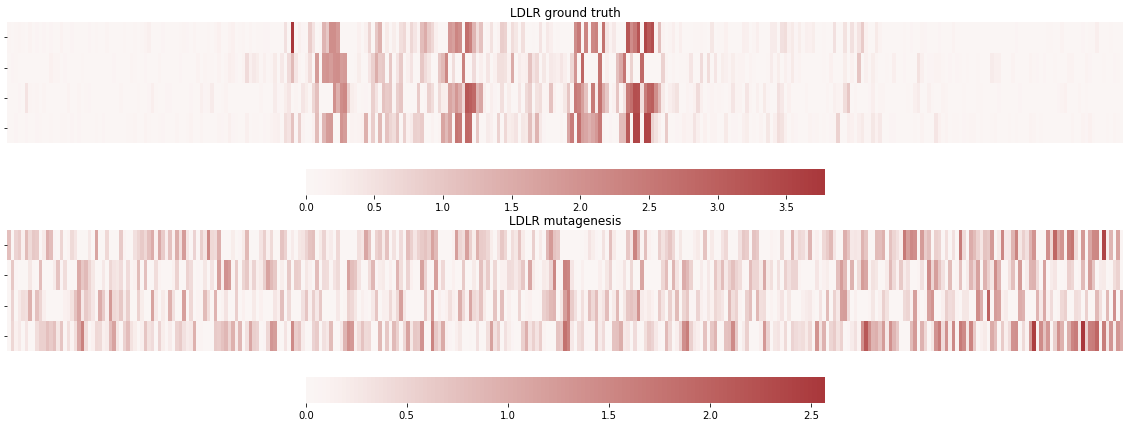

In [7]:
performance_dict = {}
idx = {'A':0,'C':1,'G':2,'T':3}
for exp in exp_list:
    exp_df = cagi_df[cagi_df['8']==exp]
    idx_df = exp_df[['0','1','2']].drop_duplicates().sort_values(by=['1'])
    exp_len = len(exp_df['1'].unique())
    effect_size = np.zeros((4,exp_len))
    predict_size = np.zeros((4,exp_len))
    
    for pos in range(0,exp_len):
        row = idx_df.iloc[pos]
        loci_df = exp_df[(exp_df['0']==row['0'])&(exp_df['1']==row['1'])&(exp_df['2']==row['2'])]
        loci_idx = loci_df.index
        ref_allele = loci_df['3'].drop_duplicates().values
        alt_allele = loci_df['4'].values.tolist()
        diff = loci_df['6'].values

        effect_size[itemgetter(*alt_allele)(idx),pos] =np.absolute(diff)
        predict_size [itemgetter(*alt_allele)(idx),pos] =np.absolute(llr[loci_idx])
    
    r_value = stats.pearsonr(effect_size.flatten(),predict_size.flatten())
    performance_dict[exp] = r_value[0]
    if plot_figure:
        fig,ax = plt.subplots(2,1,figsize = (20,7))
        #fig2=plt.figure(figsize = (20,2))
        fig1 = sns.heatmap(effect_size,cmap = 'vlag',
                            center = 0,
                            #annot = exp_annot,fmt = '',
                        cbar_kws = dict(use_gridspec=False,location="bottom"),
                        ax = ax[0]);
        ax[0].tick_params(left=True, bottom=False);
        #ax.set_yticklabels(['A','C','G','T'],size = 1);
        ax[0].set_yticklabels([])
        ax[0].set_xticklabels([]);
        ax[0].set_title(exp+' ground truth')
        #plt.tight_layout()

        #fig3=plt.figure(figsize = (20,2))
        fig2 = sns.heatmap(predict_size,cmap = 'vlag',
                            center = 0,
                            #annot = pred_annot,fmt = '',
                            cbar_kws = dict(use_gridspec=False,location="bottom"),
                            ax = ax[1]);
        ax[1].tick_params(left=True, bottom=False);
        #ax.set_yticklabels(['A','C','G','T'],size = 1);
        ax[1].set_yticklabels([])
        ax[1].set_xticklabels([])
        ax[1].set_title(exp+' mutagenesis')

In [8]:
performance_dict

{'HBB': 0.24527449617476965,
 'SORT1': 0.19728104837467672,
 'TERT-GBM': 0.33153109739339265,
 'PKLR': 0.20252926134110769,
 'MYCrs6983267': 0.29480454298327957,
 'IRF6': 0.1765341059678167,
 'MSMB': 0.11981732575993727,
 'HBG1': 0.1382942514263495,
 'TERT-HEK293T': 0.2841776775969338,
 'F9': 0.22765503843959278,
 'ZFAND3': 0.16514463544231148,
 'HNF4A': 0.12651406031949075,
 'IRF4': 0.09018390703028045,
 'GP1BB': 0.24913976080987973,
 'LDLR': 0.05669310453447756}

In [9]:
np.array(list(performance_dict.values())).mean()

0.19370495423961973